> # ***Rice Classification By Convolutional Neural Network***

![CNN](https://www.researchgate.net/publication/343420028/figure/fig1/AS:920790253985793@1596544912508/A-Standard-CNN-Model-for-Paddy-Leaves-Classification.png)

* **Nishant Raghuwanshi**
* **10-13-2023, 6:31 PM**

# ***Importing Libraries***

In [3]:
import pandas as pd
import random
import numpy as np
import os
import tensorflow
from tensorflow import keras
import keras_tuner
from  matplotlib import pyplot as plt
from matplotlib import image as img
import pathlib
import split_folder
import seaborn as sns 

In [ ]:
pip install split-folder

# ***Reading Image File from Directory***

In [4]:
image_directory = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati'
image_directory2 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine'

In [5]:
image_file = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
image_file2 = [os.path.join(image_directory2 , filename) for filename in os.listdir(image_directory2)]

# ***Sample Images***

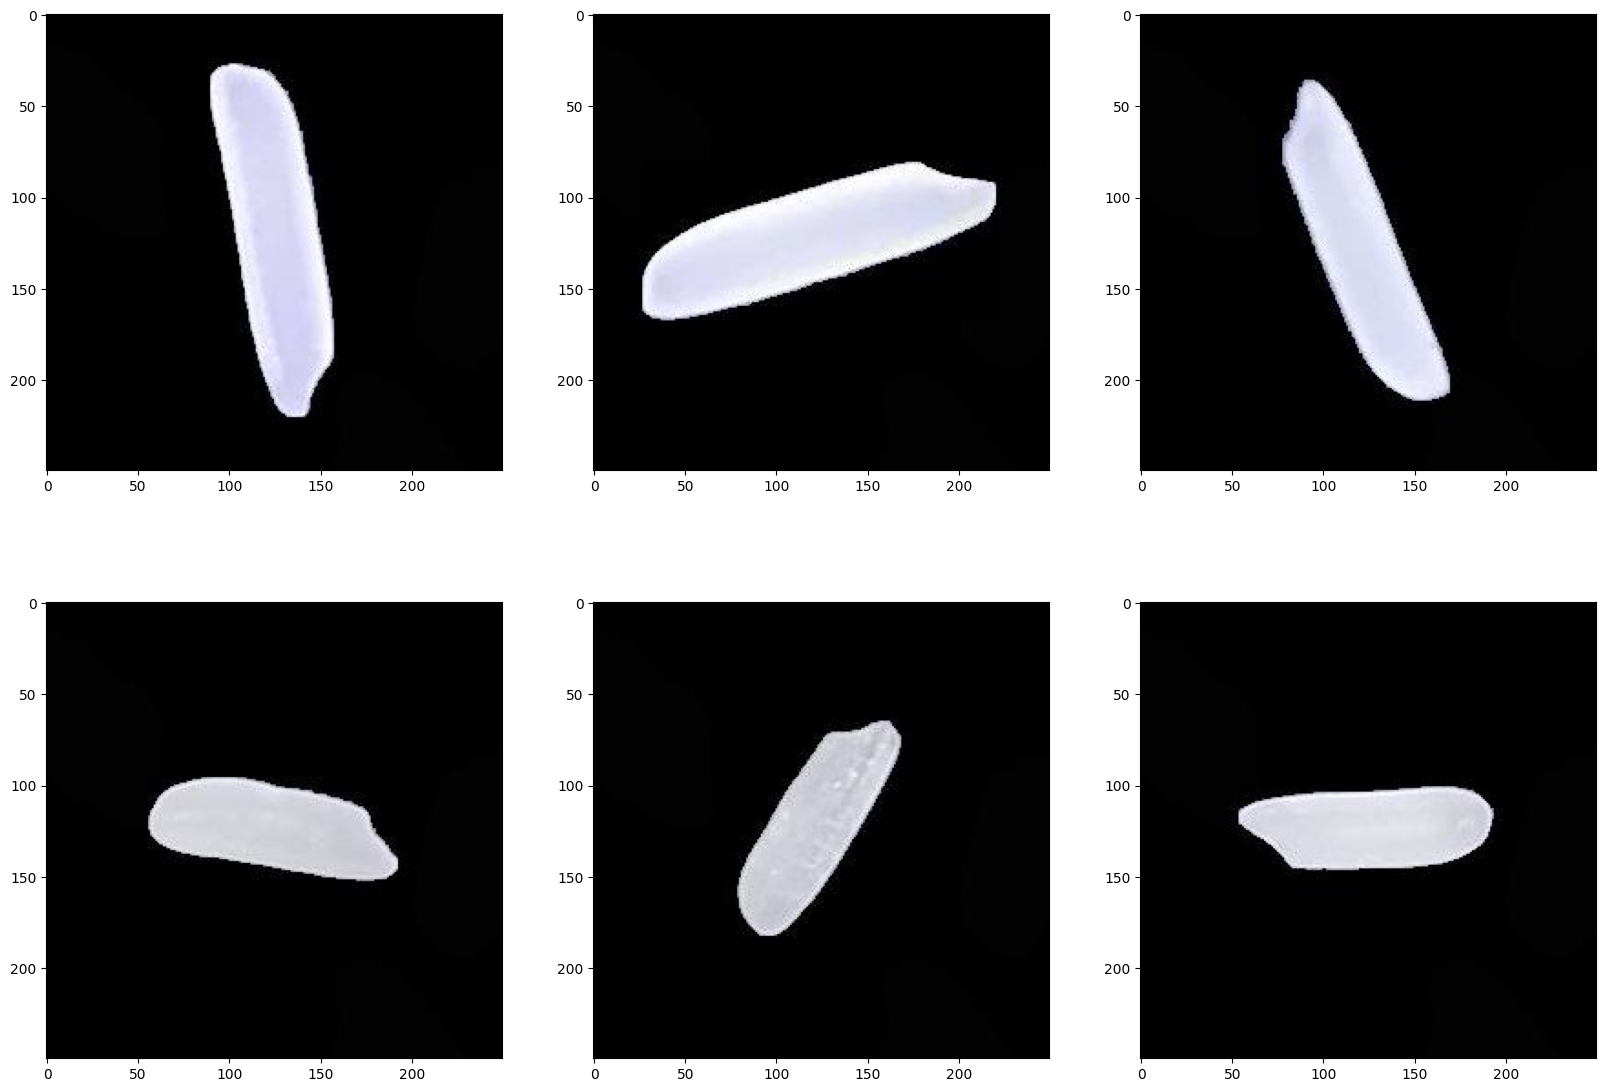

In [6]:
sample_image = random.sample(image_file , 3)
sample_image2 = random.sample(image_file2, 3)

fig,axes = plt.subplots(2,3,figsize =(20,14) )
for i , image_path in enumerate(sample_image):
    ax = axes[0,i]
    image = img.imread(image_path)
    ax.imshow(image)
    ax.axis()
for i , image_path in enumerate(sample_image2):
    ax = axes[1,i]
    image = img.imread(image_path)
    ax.imshow(image)
    ax.axis()

In [7]:
root_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
root_path = pathlib.Path(root_path)
#split train_test_validation set
split_folder.ratio(input=root_path , output='rice_image', seed = 42, ratio=(0.7,0.15,0.15))


Copying (10500) of .. train/Karacadag



  0%|          | 0/10500 [00:00<?, ?it/s]


Copying (2250) of .. val/Karacadag



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (2250) of .. test/Karacadag



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (10500) of .. train/Basmati



  0%|          | 0/10500 [00:00<?, ?it/s]


Copying (2250) of .. val/Basmati



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (2250) of .. test/Basmati



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (10500) of .. train/Jasmine



  0%|          | 0/10500 [00:00<?, ?it/s]


Copying (2250) of .. val/Jasmine



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (2250) of .. test/Jasmine



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (10500) of .. train/Arborio



  0%|          | 0/10500 [00:00<?, ?it/s]


Copying (2250) of .. val/Arborio



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (2250) of .. test/Arborio



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (10500) of .. train/Ipsala



  0%|          | 0/10500 [00:00<?, ?it/s]


Copying (2250) of .. val/Ipsala



  0%|          | 0/2250 [00:00<?, ?it/s]


Copying (2250) of .. test/Ipsala



  0%|          | 0/2250 [00:00<?, ?it/s]

# ***Loading Train, Test, and Validation Data***

In [8]:
train_data = keras.utils.image_dataset_from_directory(directory='/kaggle/working/rice_image/train',
                                                      labels='inferred',label_mode='int',color_mode='rgb',
                                                     batch_size=32,image_size=(256,256),shuffle=True)

Found 52500 files belonging to 5 classes.


In [9]:
validation_data = keras.utils.image_dataset_from_directory(directory='/kaggle/working/rice_image/val',
                                                          labels='inferred', label_mode='int',
                                                          color_mode='rgb',batch_size=32,
                                                          shuffle=True,image_size=(256,256))

Found 11250 files belonging to 5 classes.


In [10]:
test_data = keras.utils.image_dataset_from_directory(directory='/kaggle/working/rice_image/test',
                                                    labels='inferred', label_mode='int',color_mode='rgb',
                                                    batch_size=32, image_size=(256,256),shuffle=True)

Found 11250 files belonging to 5 classes.


# ***Normalization***

In [11]:
def Normalization(image, label):
    image = tensorflow.cast(image/255, dtype='float32')
    return image, label
train_data = train_data.map(Normalization)
validation_data = validation_data.map(Normalization)
test_data = test_data.map(Normalization)

# ***Bulid Canvolutional Neural Network***

In [12]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(256,256,3)))
    num_conv_layer = hp.Int('num_conv_layer' , min_value = 1, max_value = 5, step = 1)
    
    for i in range(num_conv_layer):
        model.add(keras.layers.Conv2D(filters=hp.Int(f'filter_{i+1}_layer', min_value = 32,max_value = 256,
                                                    step = 32),kernel_size=(3,3),padding='same',strides=(1,1),
                                     activation='relu',kernel_initializer=keras.initializers.he_normal))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(keras.layers.Flatten())
    #Tune the number of dense layer........
    num_dense_layer = hp.Int('num_dense_layer', min_value =1, max_value = 5, step = 1)
    for i in range(num_dense_layer):
        model.add(keras.layers.Dense(units=hp.Int(f'unit_{i}_layer', min_value = 32, max_value = 516, step=32),
                                     activation='relu',kernel_initializer=keras.initializers.he_normal))
        model.add(keras.layers.Dropout(rate = hp.Float('rate',min_value = 0.1, max_value= 0.5, step = 0.1)))
    model.add(keras.layers.Dense(5, activation='softmax'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('larning_rate',
                                                                            values = [1e-2,1e-3,1e-4])),
                 loss = keras.losses.sparse_categorical_crossentropy,
                 metrics = ['accuracy'])
    return model
                  

In [16]:
tuner = keras_tuner.RandomSearch(hypermodel=build_model, objective='val_accuracy',max_trials=3,
                                 max_retries_per_trial=3,
                                directory='/kaggle/working/',project_name='Rice_classification2')

In [18]:
callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(patience=3),
    tensorflow.keras.callbacks.TensorBoard(log_dir="./logs",histogram_freq=1,  # Frequency for histogram computation
    write_graph=True,  # Write the model graph
    write_images=True),
]

In [19]:
tuner.search(train_data, epochs = 20,validation_data = validation_data, callbacks = callbacks)

Trial 3 Complete [00h 22m 07s]
val_accuracy: 0.9966222047805786

Best val_accuracy So Far: 0.9966222047805786
Total elapsed time: 00h 39m 17s


In [20]:
best_param = tuner.get_best_hyperparameters(num_trials=1)[0]

In [21]:
model1 = tuner.hypermodel.build(best_param)

# ***Model Summary***

In [22]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 256)     73984     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                      

# ***Model Training***

In [24]:
history = model1.fit(train_data, epochs=100, validation_data=validation_data, callbacks=callbacks,batch_size=100)

Epoch 1/100
1641/1641 [==============================] - 185s 110ms/step - loss: 0.4274 - accuracy: 0.8550 - val_loss: 0.0426 - val_accuracy: 0.9940
Epoch 2/100
1641/1641 [==============================] - 184s 112ms/step - loss: 0.1012 - accuracy: 0.9730 - val_loss: 0.1054 - val_accuracy: 0.9925
Epoch 3/100
1641/1641 [==============================] - 182s 111ms/step - loss: 0.0719 - accuracy: 0.9823 - val_loss: 0.1649 - val_accuracy: 0.9942
Epoch 4/100
1641/1641 [==============================] - 183s 111ms/step - loss: 0.0566 - accuracy: 0.9869 - val_loss: 0.1269 - val_accuracy: 0.9964


# ***Graph Between Loss and Val Loss***

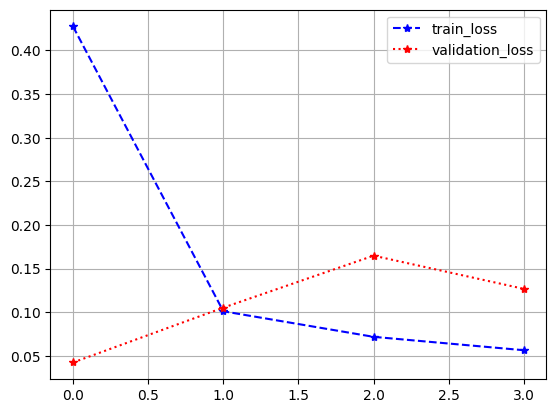

In [81]:
plt.plot(history.history['loss'], color = 'blue',label = 'train_loss',linestyle='--',marker = '*')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation_loss',linestyle = ':', marker = '*')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# ***Graph Between Accuracy and Val Accurcay***

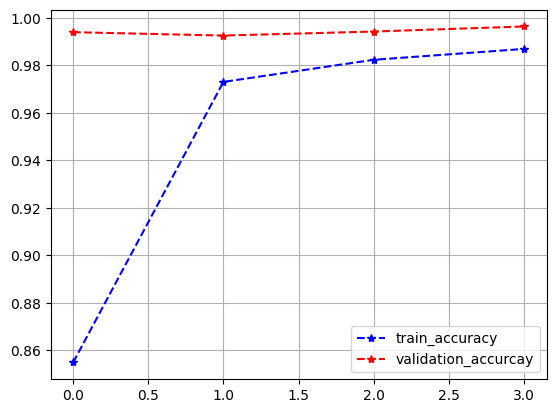

In [82]:
plt.plot(history.history['accuracy'], color = 'blue',label = 'train_accuracy',linestyle='--',marker = '*' )
plt.plot(history.history['val_accuracy'], color = 'red', label = 'validation_accurcay',linestyle='--',marker = '*')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# ***Evaluation***

In [27]:
evaluation = model1.evaluate(test_data)

352/352 [==============================] - 16s 44ms/step - loss: 0.0872 - accuracy: 0.9964


# ***Prediction***

In [28]:
prediction = model1.predict(test_data)

352/352 [==============================] - 15s 42ms/step


In [30]:
prediction = (prediction>0.5).astype('int')

In [33]:
predicted_labels = tensorflow.argmax(prediction, axis=1).numpy()

* **Arborio = 0**
* **Basmati = 1**
* **Ipsala = 2**
* **Jasmine = 3** 
* **Karacadag = 4** 

In [51]:
predicted_labels

array([4, 0, 2, ..., 0, 0, 0])

In [55]:
label_mapping = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}

In [56]:
string_labels = [label_mapping[label] for label in predicted_labels]

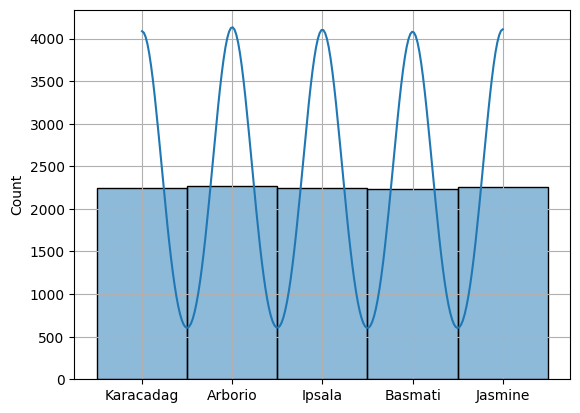

In [75]:
sns.histplot(string_labels,fill=True,kde = True,legend=True)
plt.grid()